In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sy
from sympy import Derivative, Symbol
from scipy.special import sph_harm 
from scipy import integrate
from scipy.integrate import dblquad
from scipy.integrate import quad
%run -i func_proj_reconst.ipynb
%run -i func_zeta_pressure.ipynb

Input Streamfunction:

$$
\psi(\theta, \phi)= Re(Y_n^m(\theta,\phi))
= Re(Y_2^1(\theta,\phi)) = Re(A\cos\theta\sin\theta e^{i\phi}) = A\cos\theta\sin\theta \cos\phi
$$

$$
A = \frac{-1}{2}\sqrt{\frac{15}{2\pi}}
$$

Analytical expression for U and V:

$$
U(\theta, \phi)=-\frac{1}{r} \frac{\partial \psi}{\partial \phi} = \frac{A\sin\phi}{r}\cos\theta\sin\theta
$$

$$
V(\theta, \phi)=\frac{\sin \theta}{r}\frac{\partial \psi}{\partial \theta} = \frac{A\cos\phi}{r}(\cos^2\theta\sin\theta-\sin^3\theta)
$$

In [2]:
N_t = 100
N_p = 200
#make the starting point very small
theta = np.linspace(1e-6, np.pi, N_t) #100pts 
phi = np.linspace(0, 2*np.pi, N_p)  #200pts
t, p = np.meshgrid(theta, phi) #create a matrix with size theta x phi (100x200), 20000 pts
lMax = 20 #lMax is N
omega = 3.6 #omega is te angular rotation
nu = 1.5  #\nu is kinematic viscosity
T = 4 #total time
r = 1 #let r=1

In [3]:
A = (-1/2)*((15/(2*np.pi))**(1/2))
psi_tp_a = A*np.cos(t)*np.sin(t)*np.cos(p) #nanalytical psi
psi_tp = np.real(sph_harm (1, 2, p.reshape(-1), t.reshape(-1)).reshape(N_p, N_t)) #numerical psi

In [4]:
#U_tp_n is the numerical expression of U_tp
U_tp_n = -(1/r)*np.gradient(psi_tp, phi, axis=0)
V_tp_n = (np.sin(t)/r)*np.gradient(psi_tp, theta, axis=1)

U_tp = (A/r)*np.cos(t)*np.sin(t)*np.sin(p) #this is obtained by analytical calculation
V_tp = (A*np.cos(p)/r)*(np.cos(t)**2*np.sin(t)-np.sin(t)**3)

psi_nm = projection(psi_tp, theta, phi, lMax)
psi_TP = reconstruction(psi_nm, theta, phi, lMax) #reconstructed


In [5]:
u_nm = projection(U_tp, theta, phi, lMax) #project U_tp to u_nm
v_nm = projection(V_tp, theta, phi, lMax) 

U_TP = reconstruction(u_nm, theta, phi, lMax) #reconstructed U(theta, phi) using u_nm
V_TP = reconstruction(v_nm, theta, phi, lMax) 

In [17]:
u_nm_n = projection(U_tp_n, theta, phi, lMax) #project U_tp to u_nm
v_nm_n = projection(V_tp_n, theta, phi, lMax) 

U_TP_n = reconstruction(u_nm_n, theta, phi, lMax) #reconstructed U(theta, phi) using u_nm
V_TP_n = reconstruction(v_nm_n, theta, phi, lMax) 

Analytical expression of different quantities:
$$
\zeta = (\nabla \times \hat{u})_r = \frac{1}{r\sin\theta}(\frac{\partial}{\partial \theta}(u_\phi\sin\theta)-\frac{\partial}{\partial \phi}u_\theta) = \frac{1}{r\sin\theta}(\frac{\partial}{\partial \theta}V-\frac{\partial}{\partial\phi}\frac{U}{\sin\theta})
$$

$$
U'(\theta, \phi)=V\zeta+2\Omega V \cos\theta
$$

$$
V'(\theta, \phi)=-U\zeta-2\Omega U \sin \theta
$$

$$
\nabla^2P=-\frac{\partial U'}{\partial \cos\theta}+\frac{1}{\sin^2\theta}\frac{\partial V'}{\partial \phi} = \frac{1}{\sin\theta}\frac{\partial U'}{\partial \theta}+\frac{1}{\sin^2\theta}\frac{\partial V'}{\partial \phi}
$$

$$
p_{nm}=\frac{-1}{n(n+1)}(\nabla^2P)_{nm}
$$

In [62]:
zeta_nm = np.zeros((lMax, lMax), dtype=complex)
for m in range (1, lMax):
    for n in range (m, lMax):
        zeta_nm[n,m] = -1j*(n*(n+1)/m)*u_nm[n,m]

zeta_tp = reconstruction(zeta_nm, theta, phi, lMax)
U1_tp = V_tp*zeta_tp+2*omega*np.cos(t)*V_tp #U'(theta, phi)
V1_tp = -1*U_tp*zeta_tp-2*omega*np.sin(t)*U_tp #V'(theta, phi)
u1_nm = projection(U1_tp, theta, phi, lMax) #u'_nm
v1_nm = projection(V1_tp, theta, phi, lMax) #v'_nm

In [24]:
#divP = -1*np.gradient(U1_tp, np.cos(theta), axis=1)+(1/(np.sin(t)**2))*np.gradient(V1_tp, phi, axis=0) #\nabla^2 P
divP = (1/np.sin(t))*np.gradient(U1_tp, theta, axis=1)+(1/(np.sin(t)**2))*np.gradient(V1_tp, phi, axis=0) #\nabla^2 P

divP_nm = projection(divP, theta, phi, lMax) #\nabla^2 P_nm
p_nm = np.zeros((lMax, lMax), dtype=complex)
for m in range (1, lMax):
    for n in range (m, lMax):
        p_nm[n,m] = (-1/(n*(n+1)))*divP_nm[n,m]

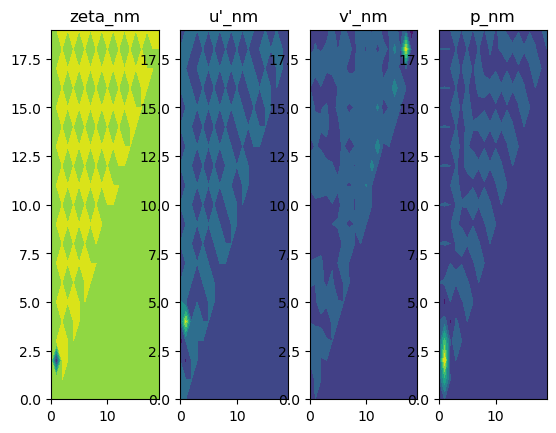

In [8]:
fig,ax = plt.subplots(1,4);
ax[0].contourf(np.real(zeta_nm))
ax[0].set_title('zeta_nm')
ax[1].contourf(np.real(u1_nm))
ax[1].set_title("u'_nm")
ax[2].contourf(np.real(v1_nm))
ax[2].set_title("v'_nm")
ax[3].contourf(np.real(p_nm))
ax[3].set_title('p_nm')
fig.show()

For the above arbitrary stream function $$ \psi(\theta, \phi)= Re(Y_n^m(\theta,\phi))
= Re(Y_2^1(\theta,\phi)) = Re(A\cos\theta\sin\theta e^{i\phi}) = A\cos\theta\sin\theta \cos\phi
$$

The analytical expression of the harmonics quantities is calculated as:

$$
\zeta = \frac{A\cos\phi}{r^2}(-5\cos\theta\sin\theta+\frac{\cos^3\theta}{\sin\theta}-\frac{\cos\theta}{\sin\theta})
$$

$$
U' = \frac{A^2\cos^2\phi}{r^3} (5\cos\theta\sin^4\theta + \cos^5\theta - 6\cos^3\theta\sin^2\theta - \cos^3\theta + \cos\theta\sin^2\theta) + \frac{2\Omega A\cos\phi}{r}(\cos^3\theta\sin\theta - \cos\theta\sin^3\theta)
$$


$$
V' = \frac{-A^2\cos\phi\sin\phi}{r^3} (-5\cos^2\theta\sin^2\theta + \cos^4\theta -\cos^2\theta) + \frac{-2\Omega A\sin\phi}{r}\cos\theta\sin^2\theta
$$

$$
\nabla^2P = \frac{A^2\cos^2\phi}{r^3}(38\cos^2\theta\sin^2\theta - 17\cos^4\theta + 5\cos^2\theta - 5\sin^4\theta - \sin^2\theta) + \frac{2\Omega A\cos\phi}{r}(-6\cos^2\theta\sin\theta + \frac{\cos^4\theta}{\sin\theta} + \sin^3\theta) + \frac{-A^2}{r^3}(\cos^2\phi - \sin^2\phi) (-5\cos^2\theta + \frac{\cos^4\theta}{\sin^2\theta} - \frac{\cos^2\theta}{\sin^2\theta}) + \frac{-2\Omega A \cos\phi}{r}\cos\theta
$$

$$\textit{"_a" denotes the analytical expression obtained by hand (equations above)}$$

$$
\zeta = \frac{A\cos\phi}{r^2}(-5\cos\theta\sin\theta+\frac{\cos^3\theta}{\sin\theta}-\frac{\cos\theta}{\sin\theta})
$$

In [69]:
zeta_tp_a = A*np.cos(p)*(-5*np.cos(t)*np.sin(t)+(np.cos(t)**3/np.sin(t))-(np.cos(t)/np.sin(t)))/(r**2) 

zeta_nm_a = projection(zeta_tp_a, theta, phi, lMax)
print ("max difference between analytical and numerical zeta_tp\n",np.amax(np.abs(zeta_tp_a-zeta_tp)))
print ("max difference between analytical and numerical zeta_nm\n",np.amax(np.abs(zeta_nm_a-zeta_nm)))

#plt.plot(zeta_tp-zeta_tp_a); 
#plt.plot(zeta_nm-zeta_nm_a)

max difference between analytical and numerical zeta_tp
 0.010742869764550411
max difference between analytical and numerical zeta_nm
 0.002315789365642499


$$
U' = \frac{A^2\cos^2\phi}{r^3} (5\cos\theta\sin^4\theta + \cos^5\theta - 6\cos^3\theta\sin^2\theta - \cos^3\theta + \cos\theta\sin^2\theta) + \frac{2\Omega A\cos\phi}{r}(\cos^3\theta\sin\theta - \cos\theta\sin^3\theta)
$$

In [67]:
a_U = A**2*np.cos(p)**2*(5*np.cos(t)*np.sin(t)**4+np.cos(t)**5-6*np.cos(t)**3*np.sin(t)**2-np.cos(t)**3+np.cos(t)*np.sin(t)**2)/(r**3)
b_U = 2*omega*A*np.cos(p)*(np.cos(t)**3*np.sin(t)-np.cos(t)*np.sin(t)**3)/r

U1_tp_a=a_U+b_U
u1_nm_a = projection(U1_tp_a, theta, phi, lMax)

print ("max difference between analytical and numerical U1_tp\n",np.amax(np.abs(U1_tp_a-U1_tp)))
print ("max difference between analytical and numerical U1_nm\n",np.amax(np.abs(u1_nm_a-u1_nm)))

#plt.plot(U1_tp_a-U1_tp)
#plt.plot(u1_nm_a-u1_nm)

max difference between analytical and numerical U1_tp
 0.0010490908715388159
max difference between analytical and numerical U1_nm
 0.00031636548018833645


$$
V' = \frac{-A^2\cos\phi\sin\phi}{r^3} (-5\cos^2\theta\sin^2\theta + \cos^4\theta -\cos^2\theta) + \frac{-2\Omega A\sin\phi}{r}\cos\theta\sin^2\theta
$$

In [68]:
a_V = -1*A**2*np.cos(p)*np.sin(p)*(-5*np.cos(t)**2*np.sin(t)**2+np.cos(t)**4-np.cos(t)**2)/(r**3)
b_V = -2*omega*A*np.sin(p)*np.cos(t)*np.sin(t)**2/r

V1_tp_a = a_V+b_V
v1_nm_a = projection(V1_tp_a, theta, phi, lMax)

print ("max difference between analytical and numerical V1_tp\n",np.amax(np.abs(V1_tp_a-V1_tp)))
print ("max difference between analytical and numerical v1_nm\n",np.amax(np.abs(v1_nm_a-v1_nm)))
 
#plt.plot(V1_tp_a-V1_tp)
#plt.plot(v1_nm_a-v1_nm)

max difference between analytical and numerical V1_tp
 0.0005567369140980771
max difference between analytical and numerical v1_nm
 0.0002035159178245654


$$
\nabla^2P = \frac{A^2\cos^2\phi}{r^3}(38\cos^2\theta\sin^2\theta - 17\cos^4\theta + 5\cos^2\theta - 5\sin^4\theta - \sin^2\theta) + \frac{2\Omega A\cos\phi}{r}(-6\cos^2\theta\sin\theta + \frac{\cos^4\theta}{\sin\theta} + \sin^3\theta) + \frac{-A^2}{r^3}(\cos^2\phi - \sin^2\phi) (-5\cos^2\theta + \frac{\cos^4\theta}{\sin^2\theta} - \frac{\cos^2\theta}{\sin^2\theta}) + \frac{-2\Omega A \cos\phi}{r}\cos\theta
$$

$\textbf{derivation already checked}$

max difference between analytical and numerical divP
 1077147041200840.0
max difference between analytical and numerical divP_nm
 1.7636331237932124


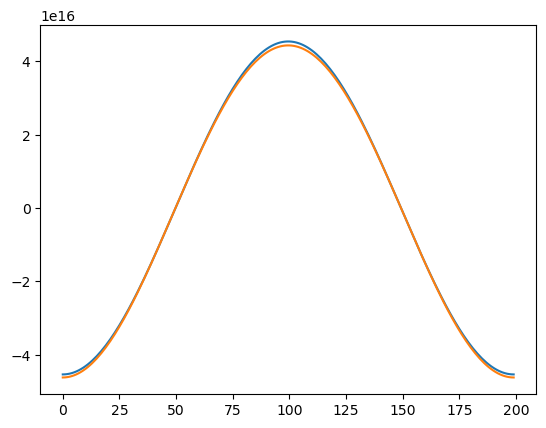

In [59]:
a_divP=A**2*np.cos(p)**2*(38*np.cos(t)**2*np.sin(t)**2-17*np.cos(t)**4+5*np.cos(t)**2-5*np.cos(t)**4-np.sin(t)**2)/(r**3)
b_divP=2*omega*A*np.cos(p)*(-6*np.cos(t)**2*np.sin(t)+(np.cos(t)**4/np.sin(t))+np.sin(t)**3)/r
c_divP=-1*A**2*(np.cos(p)**2-np.sin(p)**2)*(-5*np.cos(t)**2+(np.cos(t)**4/(np.sin(t)**2))-(np.cos(t)**2/(np.sin(t)**2)))/(r**3)
d_divP=-2*omega*A*np.cos(p)*np.cos(t)/r

divP_a=a_divP+b_divP+c_divP+d_divP
divP_nm_a = projection(divP_a, theta, phi, lMax)

print ("max difference between analytical and numerical divP\n",np.amax(np.abs(divP_a[:,99]-divP[:,99])))
print ("max difference between analytical and numerical divP_nm\n",np.amax(np.abs(divP_nm_a[0,:]-divP_nm[0,:])))

plt.plot(divP_a[:,99])
plt.plot(divP[:,99])